In [16]:
# Imports 
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.model_selection import ParameterGrid

In [17]:
# Device Configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Global Configuration 
timesteps = 50
batch_size = 64
grid_search_epochs = 50
final_epochs = 25
test_ratio = 0.2
max_len = 1000
folder_path = "./EXDATA"

use_default_params = True  # Set to False to enable grid search

Using device: cuda


In [19]:
# Input and Target Columns 
acc_input = [
    'aextx', 'Vs2', 'VdWestWall', 'Kh', 'Damping', 'M', 'K',
    'Gap', 'EffectiveGapWest', 'is_contacting'
]
acc_target = ['FCWest']

# Required Columns for Derived Features 
all_columns = list(set(acc_input + acc_target + ['s2', 'dWestWall']))

In [5]:
#  Load and preprocess a single file 
def load_file(file_path):
    df = pd.read_csv(file_path, sep='\t', engine='python')

    #  Derived Features 
    if 's2' in df.columns and 'dWestWall' in df.columns:
        df['EffectiveGapWest'] = np.maximum(0, df['s2'] - df['dWestWall'])
        df['is_contacting'] = (df['EffectiveGapWest'] < 0.01).astype(int)
    else:
        raise ValueError(f"'s2' or 'dWestWall' not found in {file_path}")

    #  Log-transform the target 
    if 'FCWest' in df.columns:
        df['FCWest'] = np.log1p(np.abs(df['FCWest'])) * np.sign(df['FCWest'])

    df = df.dropna().reset_index(drop=True)
    df = df.iloc[::10].reset_index(drop=True)  # Downsample
    return df

#  Normalize globally 
def normalize_df_with_scaler(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

#  Split a DataFrame into chunks 
def split_into_chunks(df, max_len):
    num_chunks = int(np.floor(len(df) / max_len))
    return [df.iloc[i * max_len:(i + 1) * max_len].reset_index(drop=True)
            for i in range(num_chunks) if len(df.iloc[i * max_len:(i + 1) * max_len]) > timesteps]

#  Extract spike-relevant windows 
def extract_spike_windows(df, target_col='FCWest', window_size=200, threshold=0.5):
    spike_indices = df.index[df[target_col].abs() > threshold]
    selected_windows = []

    for idx in spike_indices:
        start = max(0, idx - window_size // 2)
        end = min(len(df), idx + window_size // 2)
        window = df.iloc[start:end].copy()
        if len(window) >= timesteps + 1:
            selected_windows.append(window.reset_index(drop=True))

    return selected_windows

#  Main Preprocessing Function 
def preprocess_multiple_files(folder_path, all_columns, max_len=1000, test_ratio=0.2):
    file_paths = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.txt')])
    all_chunks = []
    spike_chunks = []
    global_df = pd.DataFrame()

    for path in file_paths:
        df = load_file(path)
        global_df = pd.concat([global_df, df], ignore_index=True)

    global_df, scaler = normalize_df_with_scaler(global_df.copy(), all_columns)

    regular_chunks = split_into_chunks(global_df, max_len)

    spike_windows = extract_spike_windows(global_df, target_col='FCWest', window_size=max_len)
    spike_chunks = [window for window in spike_windows if len(window) >= timesteps + 1]

    combined_train_chunks = regular_chunks + spike_chunks * 5

    np.random.seed(42)
    np.random.shuffle(combined_train_chunks)
    np.random.shuffle(spike_chunks)

    split_idx = int(len(combined_train_chunks) * (1 - test_ratio))
    train_chunks = combined_train_chunks[:split_idx]
    test_chunks = spike_chunks[:len(spike_chunks) // 2]  # spike-only test

    return train_chunks, test_chunks, scaler


In [22]:
#  Custom Dataset for Sequence Data 
class SequenceDataset(Dataset):
    def __init__(self, data_chunks, input_cols, target_cols, timesteps=50):
        self.samples = []
        for df in data_chunks:
            if not all(col in df.columns for col in input_cols + target_cols):
                continue
            for i in range(len(df) - timesteps):
                x_seq = df[input_cols].iloc[i:i+timesteps].values.astype(np.float32)
                y_val = df[target_cols].iloc[i+timesteps].values.astype(np.float32)
                self.samples.append((x_seq, y_val))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y)

#  Create DataLoader 
def create_loader(data_chunks, input_cols, target_cols, timesteps=50, batch_size=64):
    dataset = SequenceDataset(data_chunks, input_cols, target_cols, timesteps)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

#  Custom Weighted Loss for Spikes 
class WeightedMSELoss(nn.Module):
    def __init__(self, alpha=20.0, threshold=0.1):
        super().__init__()
        self.alpha = alpha
        self.threshold = threshold

    def forward(self, y_pred, y_true):
        weights = 1 + self.alpha * (y_true.abs() > self.threshold).float()
        loss = weights * (y_pred - y_true) ** 2
        return loss.mean()


In [24]:
#  Attention Layer 
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):

        weights = self.attn(lstm_output)  
        weights = torch.softmax(weights, dim=1)  
        context = torch.sum(weights * lstm_output, dim=1)  
        return context, weights

#  LSTM + Attention Model 
class LSTM_Attn_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size):
        super(LSTM_Attn_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.attn = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.leakyrelu = nn.LeakyReLU(0.01)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)             
        context, _ = self.attn(lstm_out)      
        out = self.leakyrelu(context)          
        return self.fc(out)                    


In [25]:
#  Grid Search 
def grid_search(train_loader, test_loader, input_size, output_size):
    best_params = None
    best_loss = float('inf')
    criterion = WeightedMSELoss(alpha=20.0, threshold=0.1)

    print("\n[GRID SEARCH] Searching for best hyperparameters...\n")
    for i, params in enumerate(ParameterGrid(grid_param_space), start=1):
        print(f"[{i}] Testing params: {params}")
        
        model = LSTM_Attn_Model(
            input_size=input_size,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout'],
            output_size=output_size
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=params['lr'])

        for epoch in range(grid_search_epochs):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

        model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                loss = criterion(model(x), y)
                total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)

        print(f"     Test Loss: {avg_loss:.6f}\n")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = params

    print(f"[GRID SEARCH COMPLETE] Best params: {best_params} with test loss: {best_loss:.6f}")
    return best_params

#  Final Training Function 
def final_training(model, train_loader, test_loader, lr, model_name="acc"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    criterion = WeightedMSELoss(alpha=20.0, threshold=0.1)
    train_losses, test_losses = [], []

    print(f"\nTraining model: {model_name}")
    for epoch in trange(final_epochs, desc=f"Epochs ({model_name})"):
        model.train()
        total_train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))
        scheduler.step()

        model.eval()
        total_test_loss = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                loss = criterion(model(x), y)
                total_test_loss += loss.item()
        test_losses.append(total_test_loss / len(test_loader))

    torch.save(model.state_dict(), f"final_lstm_model_{model_name}.pth")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(test_losses, label="Test MSE", linestyle="--")
    plt.title(f"{model_name.upper()} — Weighted MSE vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [26]:
# ==== Run Preprocessing ====
print("Preprocessing .txt files from folder...")
cached_train_data, cached_test_data, acc_scaler = preprocess_multiple_files(
    folder_path, all_columns, max_len, test_ratio
)
print(f"  Loaded chunks → Train: {len(cached_train_data)}, Test (spike-only): {len(cached_test_data)}")

# ==== Create DataLoaders ====
print("Creating DataLoaders...")
loader_acc_train = create_loader(cached_train_data, acc_input, acc_target, timesteps, batch_size)
loader_acc_test  = create_loader(cached_test_data, acc_input, acc_target, timesteps, batch_size)
print(f"  Training samples: {len(loader_acc_train.dataset)}")
print(f"  Testing samples : {len(loader_acc_test.dataset)}")

Preprocessing .txt files from folder...
  Loaded chunks → Train: 2351, Test (spike-only): 282
Creating DataLoaders...
  Training samples: 2233450
  Testing samples : 267900


In [27]:
# ==== Hyperparameter Space ====
default_params = {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.2, 'lr': 0.001}
grid_param_space = {
    'hidden_size': [64, 128],
    'num_layers': [2, 3],
    'dropout': [0.1, 0.3],
    'lr': [0.001, 0.0005]
}
input_size = len(acc_input)
output_size = len(acc_target)

In [28]:
# ==== Select Best Parameters ====
if use_default_params:
    chosen_params = default_params
else:
    chosen_params = grid_search(
        train_loader=loader_acc_train,
        test_loader=loader_acc_test,
        input_size=input_size,
        output_size=output_size
    )


Training model: acc


Epochs (acc): 100%|██████████| 25/25 [2:03:48<00:00, 297.15s/it]


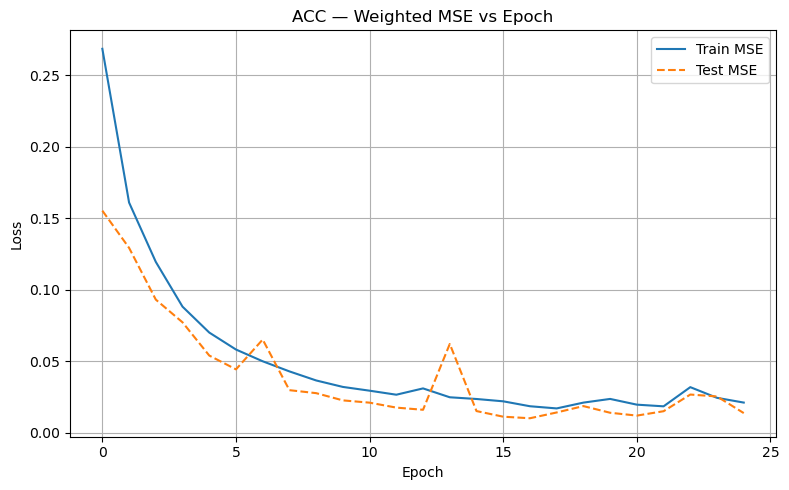

In [29]:
# ==== Instantiate and Train Final Model ====
model_acc = LSTM_Attn_Model(
    input_size=input_size,
    hidden_size=chosen_params['hidden_size'],
    num_layers=chosen_params['num_layers'],
    dropout=chosen_params['dropout'],
    output_size=output_size
).to(device)

final_training(
    model=model_acc,
    train_loader=loader_acc_train,
    test_loader=loader_acc_test,
    lr=chosen_params['lr'],
    model_name="acc"
)

In [30]:
# ==== Predict and Plot Entire File ====
def predict_and_plot_full_file(model, file_path, input_cols, target_cols, scaler,
                                model_name="acc", timesteps=50, batch_size=512):
    print(f"\n[INFO] Predicting on entire file: {os.path.basename(file_path)}")

    df = load_file(file_path)
    df_norm = df.copy()
    cols_to_norm = [col for col in scaler.feature_names_in_ if col in df.columns]
    df_norm[cols_to_norm] = scaler.transform(df[cols_to_norm])

    # Sliding window input
    X = np.array([
        df_norm[input_cols].iloc[i:i+timesteps].values.astype(np.float32)
        for i in range(len(df_norm) - timesteps)
    ])
    Y = np.array([
        df_norm[target_cols].iloc[i+timesteps].values.astype(np.float32)
        for i in range(len(df_norm) - timesteps)
    ])

    # Predict in batches
    all_preds = []
    model.eval()
    for i in range(0, len(X), batch_size):
        x_batch = torch.tensor(X[i:i+batch_size]).to(device)
        with torch.no_grad():
            pred_batch = model(x_batch).cpu().numpy()
        all_preds.append(pred_batch)
    Y_pred = np.vstack(all_preds)

    # Reconstruct arrays to inverse-transform
    dummy_true = np.zeros((len(Y), len(scaler.feature_names_in_)))
    dummy_pred = np.zeros_like(dummy_true)
    for i, col in enumerate(target_cols):
        idx = list(scaler.feature_names_in_).index(col)
        dummy_true[:, idx] = Y[:, i]
        dummy_pred[:, idx] = Y_pred[:, i]

    inv_true = scaler.inverse_transform(dummy_true)[:, [list(scaler.feature_names_in_).index(c) for c in target_cols]]
    inv_pred = scaler.inverse_transform(dummy_pred)[:, [list(scaler.feature_names_in_).index(c) for c in target_cols]]

    # Inverse log1p transform
    inv_true = np.expm1(np.abs(inv_true)) * np.sign(inv_true)
    inv_pred = np.expm1(np.abs(inv_pred)) * np.sign(inv_pred)

    for j, col in enumerate(target_cols):
        plt.figure(figsize=(14, 4))
        plt.plot(inv_true[:, j], label=f"True {col}", linewidth=1.5)
        plt.plot(inv_pred[:, j], '--', label=f"Predicted {col}", linewidth=1.5)
        plt.title(f"{model_name.upper()} — {col} — Full File")
        plt.xlabel("Time Step")
        plt.ylabel("Original Units")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return inv_true, inv_pred



=== Predicting and plotting: filtered_fp4rgm111s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp4rgm111s3_denoised.txt


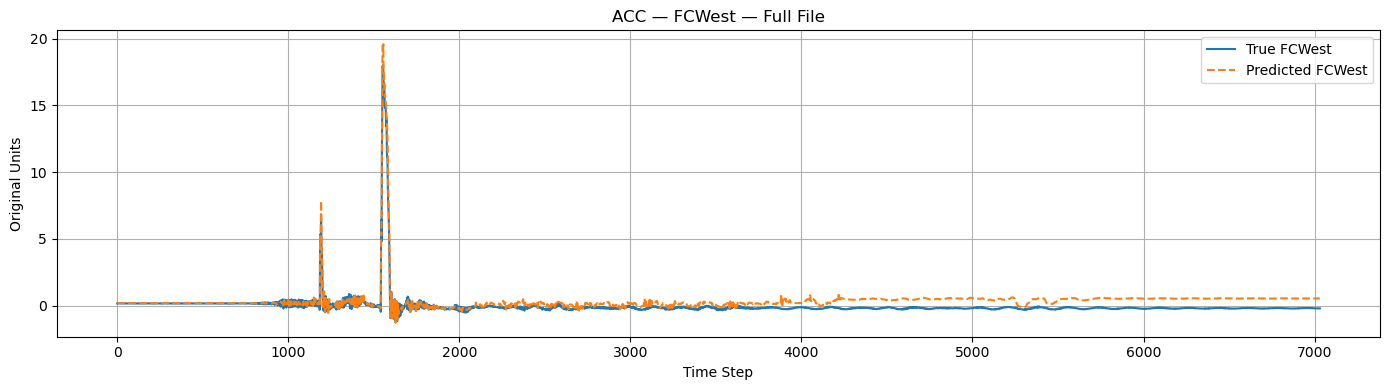


=== Predicting and plotting: filtered_fp4rgm171s2_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp4rgm171s2_denoised.txt


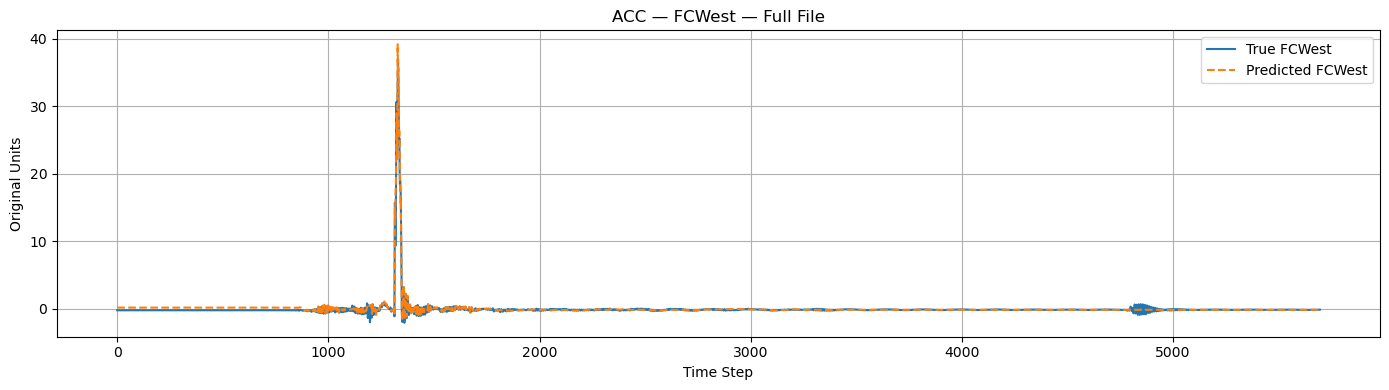


=== Predicting and plotting: filtered_fp4rgm171s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp4rgm171s3_denoised.txt


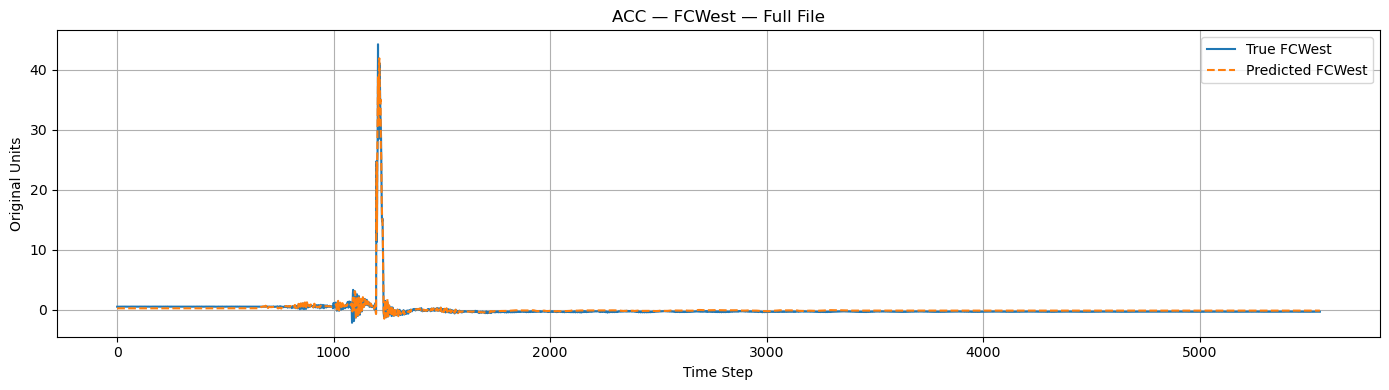


=== Predicting and plotting: filtered_fp4rgm71s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp4rgm71s3_denoised.txt


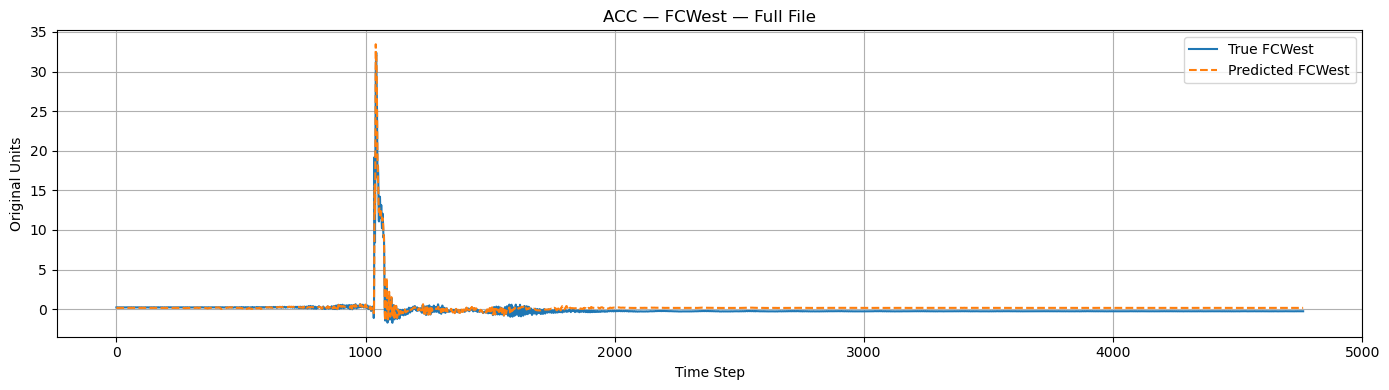


=== Predicting and plotting: filtered_fp4rngm111s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp4rngm111s3_denoised.txt


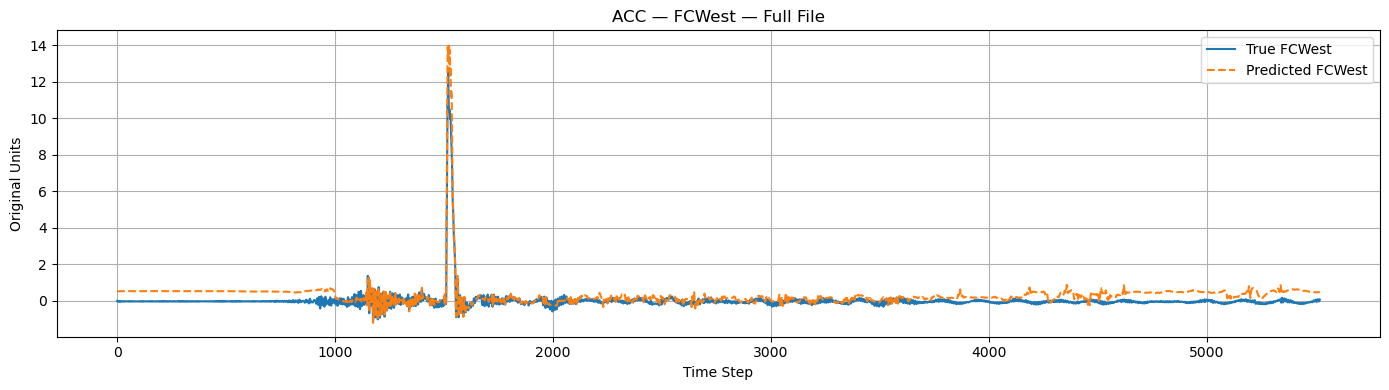


=== Predicting and plotting: filtered_fp4rngm171s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp4rngm171s3_denoised.txt


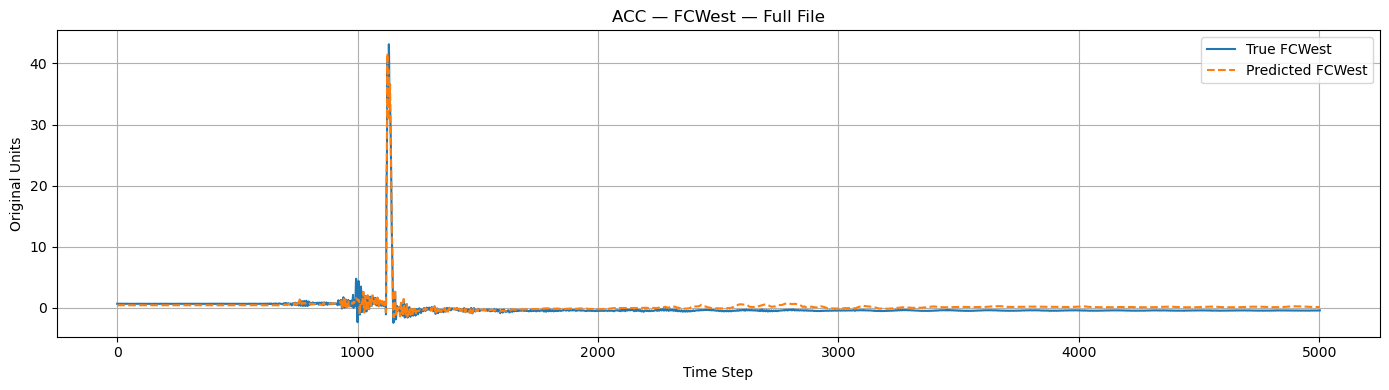


=== Predicting and plotting: filtered_fp4rngm71s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp4rngm71s3_denoised.txt


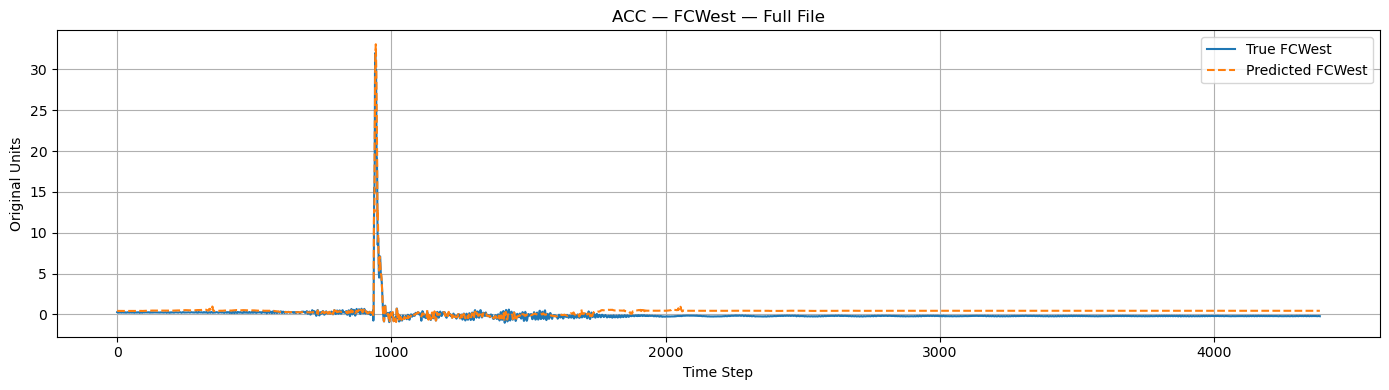


=== Predicting and plotting: filtered_fp5rgm171s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp5rgm171s3_denoised.txt


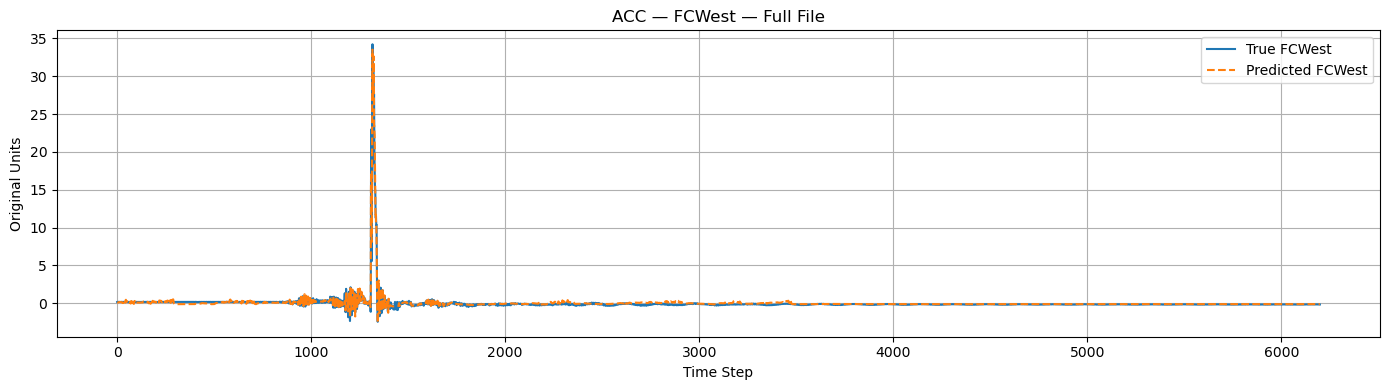


=== Predicting and plotting: filtered_fp6rgm171s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp6rgm171s3_denoised.txt


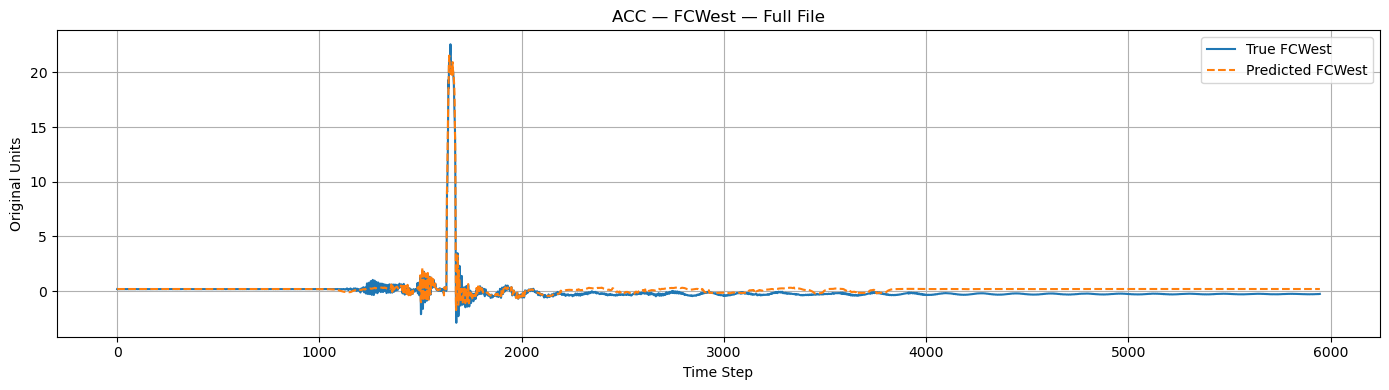


=== Predicting and plotting: filtered_fp6rngm171s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fp6rngm171s3_denoised.txt


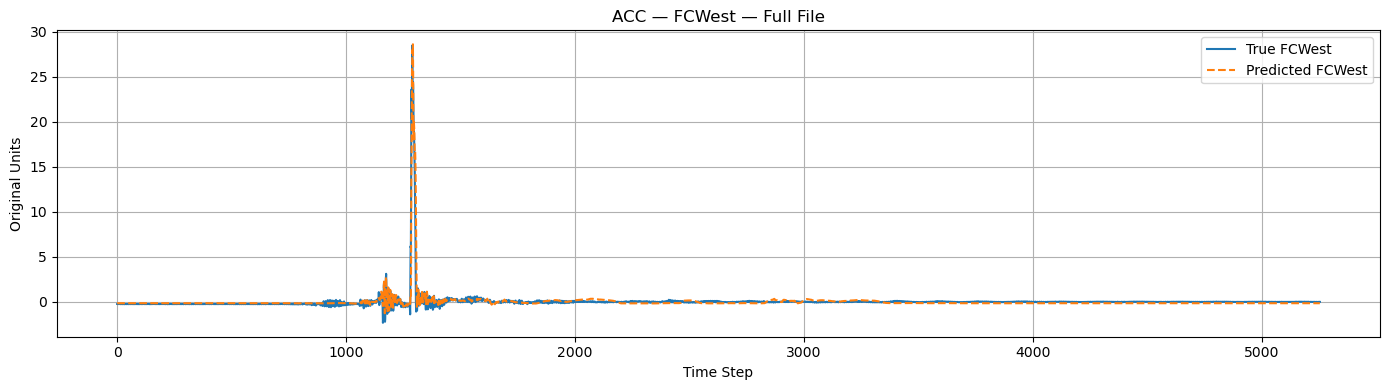


=== Predicting and plotting: filtered_fpi46gm111s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi46gm111s3_denoised.txt


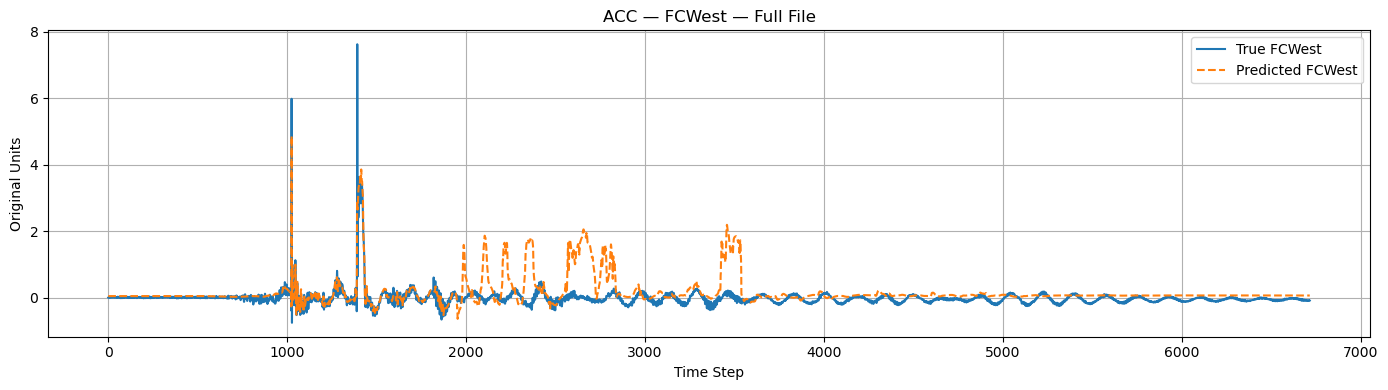


=== Predicting and plotting: filtered_fpi46gm171s2_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi46gm171s2_denoised.txt


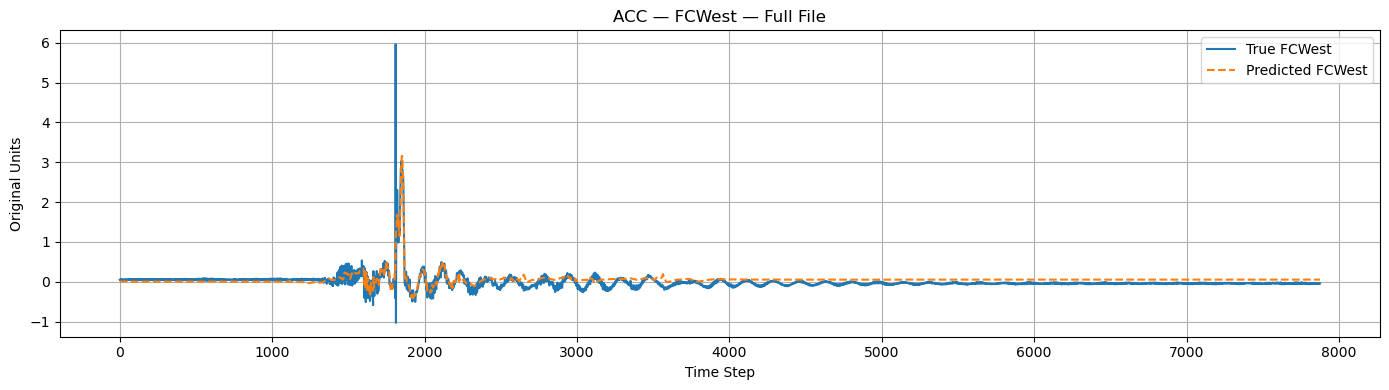


=== Predicting and plotting: filtered_fpi46gm171s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi46gm171s3_denoised.txt


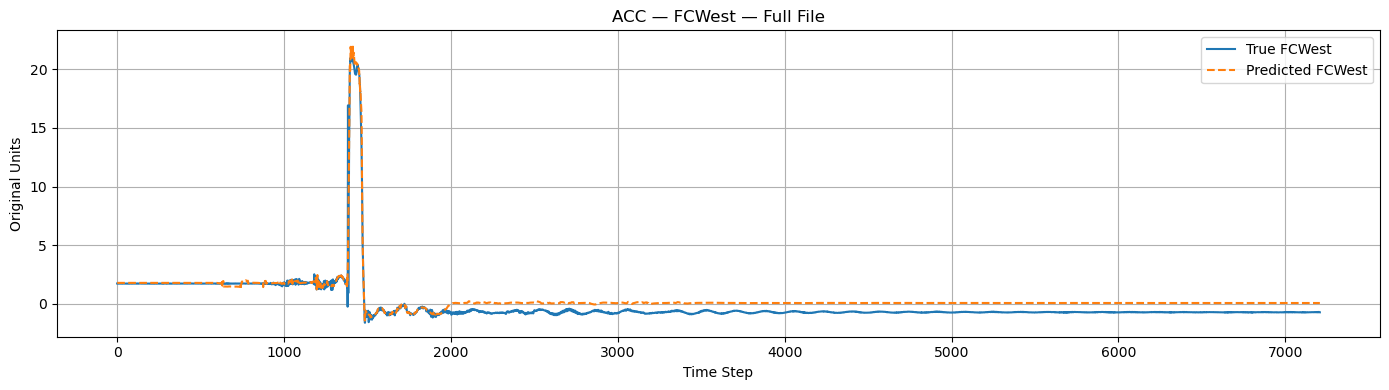


=== Predicting and plotting: filtered_fpi46gm71s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi46gm71s3_denoised.txt


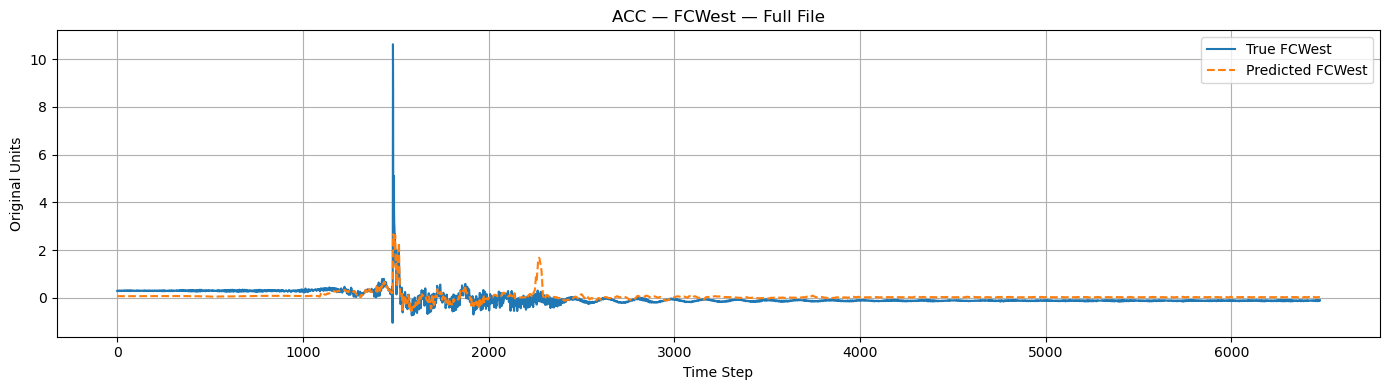


=== Predicting and plotting: filtered_fpi62gm171s1_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi62gm171s1_denoised.txt


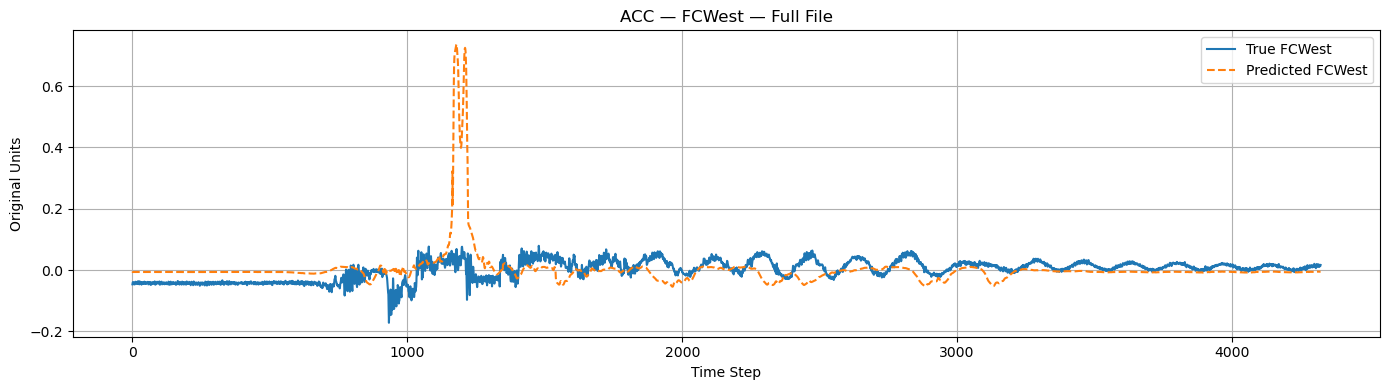


=== Predicting and plotting: filtered_fpi62gm171s2_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi62gm171s2_denoised.txt


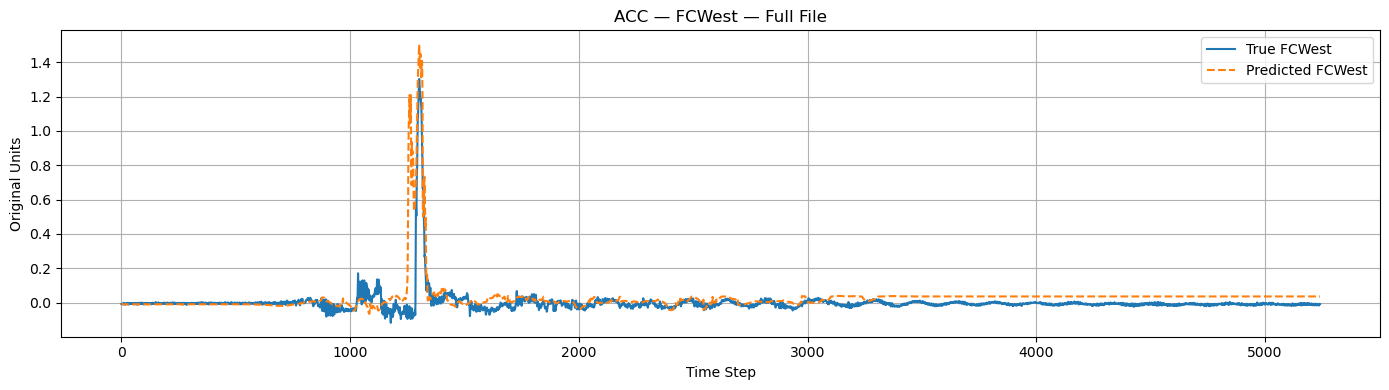


=== Predicting and plotting: filtered_fpi62gm171s3_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi62gm171s3_denoised.txt


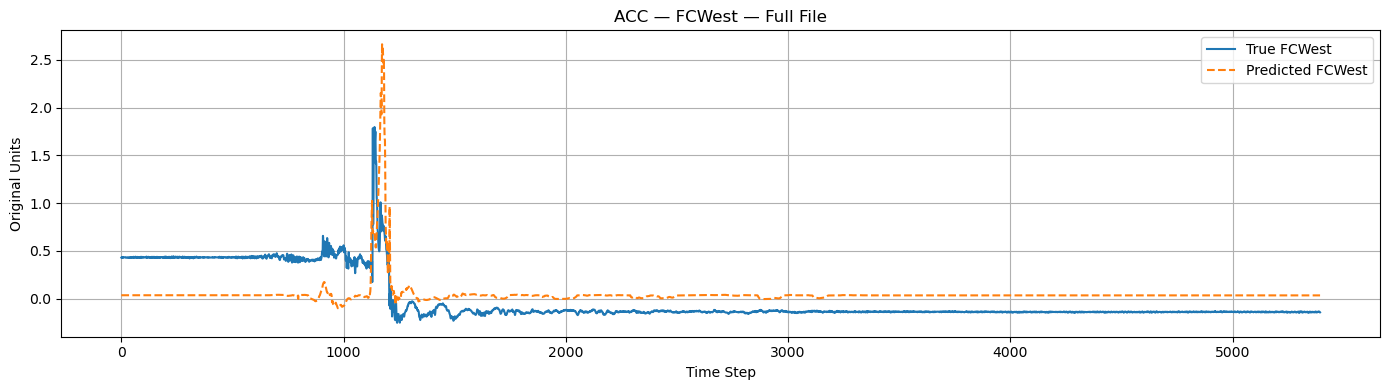


=== Predicting and plotting: filtered_fpi64gm171s2a_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi64gm171s2a_denoised.txt


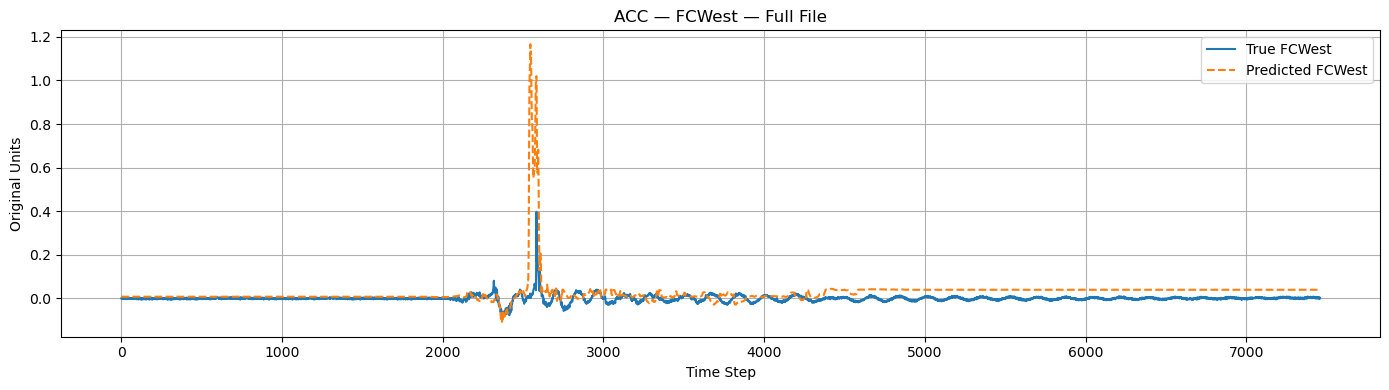


=== Predicting and plotting: filtered_fpi64gm171s3a_denoised.txt ===

[INFO] Predicting on entire file: filtered_fpi64gm171s3a_denoised.txt


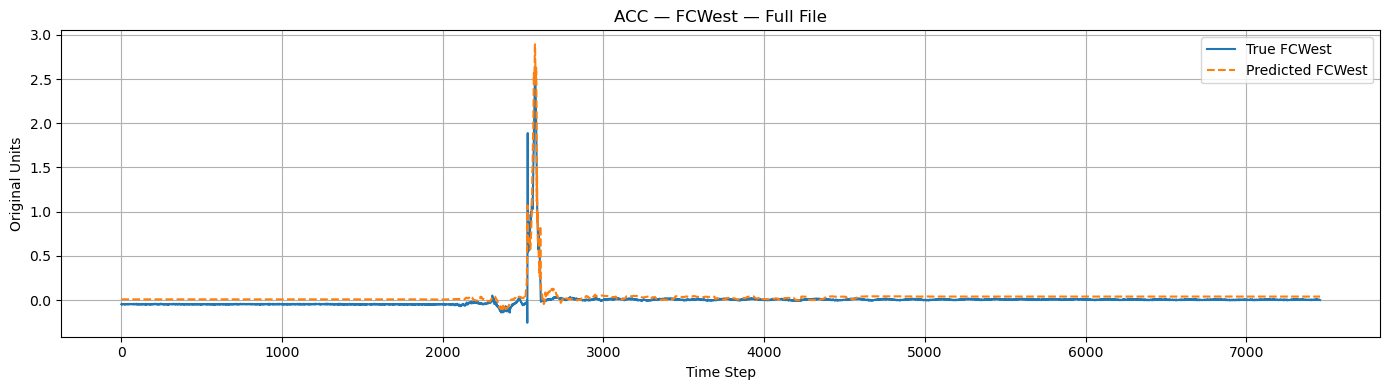

In [31]:
# ==== Loop Through Files ====
txt_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.txt')])

for fname in txt_files:
    sample_path = os.path.join(folder_path, fname)
    print(f"\n=== Predicting and plotting: {fname} ===")
    inv_true, inv_pred = predict_and_plot_full_file(
        model=model_acc,
        file_path=sample_path,
        input_cols=acc_input,
        target_cols=acc_target,
        scaler=acc_scaler,
        model_name="acc",
        timesteps=timesteps
    )
